In [276]:
import numpy as np

# Predict Air Pollution II - predict sequences

#### Exercise objectives
- Work with sequences of different lengths
- Use RNNs to return outputs for each observation in the sequences

<hr>

This exercise is a little bit different from the previous one: Here, you **observe _only_ the weather features (not the pollution)**, and you will **predict one value of air pollution *for each observation* in the input sequence**. 

What is the use-case? 
- Let's say that you have devices that are able to measure the air pollution in some places and to relate it to some weather features. That is fine! 
- But in another place, you have only weather measurements and no way to measure the air pollution.
- Then, you will use the relation between the weather features and the air pollution in some places to be able to predict the air pollution based on the weather features in another places. 

![image.png](attachment:image.png)

## 1. Data

👇 We load below the same dataset than in previous challenge. `pm2.5` is your target column. This time, it will not be a feature

In [277]:
import pandas as pd
df = pd.read_csv('data.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
df

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,,
1,NaN,-11.0,-21,1021.0,0,0,1.79
2,NaN,-12.0,-21,1020.0,0,0,4.92
3,NaN,-11.0,-21,1019.0,0,0,6.71
4,NaN,-14.0,-21,1019.0,0,0,9.84
5,NaN,-12.0,-20,1018.0,0,0,12.97
...,...,...,...,...,...,...,...
43820,8.0,-2.0,-23,1034.0,0,0,231.97
43821,10.0,-3.0,-22,1034.0,0,0,237.78
43822,10.0,-3.0,-22,1034.0,0,0,242.70


We separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training. And the last 20% in the test set. We also scale the data so as to have them in the same range

In [278]:
# Time Serie split
splitting_point = int(0.8*len(df))

df_train = df.iloc[:splitting_point]
df_test = df.iloc[splitting_point:]



In [279]:
# Scale with MinMaxScale
from sklearn.preprocessing import MinMaxScaler
columns = df.columns


scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.head()

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
0,NaN,0.133333,0.196721,0.545455,0.0,0.0,0.002290
1,NaN,0.116667,0.196721,0.527273,0.0,0.0,0.007639
2,NaN,0.133333,0.196721,0.509091,0.0,0.0,0.010698
3,NaN,0.083333,0.196721,0.509091,0.0,0.0,0.016047
4,NaN,0.116667,0.213115,0.490909,0.0,0.0,0.021396


## 2. Prepare sequences

### 2.1 Create (X,y)

Reuse your functions from previous challenge to answer this new one:

❓ **Question** ❓ Write a function `get_X_y(df, sequence_lengths)` that, given a input dataframe `df`, returns a dataset `(X, y)` where `X` are sequences of observations and `y` are their related pollution levels.

- Each observation corresponds to the weather features : TEMP, DEWP, PRES, Ir, Is, Iws. 
- If a sequence input contains `n` observations from Day `i` to Day `i+n`, then the corresponding values to predict are the sequence of pollution levels from Day `i` to Day `i+n` too.

❗ **Remark 1** In the last exercise, all the sequences had the same lengths. Here, they change with respect to the `sequence_lengths` argument, which is a list of integers:
- For instance, if `sequence_lengths = [7, 9, 6]`, $X$ will corresponds to three sequences: the first one with 7 observations, the second one with 9 observations and the third one with 6 observations.
- the length of `sequence_lengths` corresponds to the number of sequence you want to subsample from your initial sequence
- the $i$-th value of `sequence_lengths` corresponds to the length of the $i$-th sequence.

❗ **Remark 2** You are free to do whatever you want with the missing values that are in the inputs and outputs. The idea is not to spend much time on them but to get usable data.

In [280]:
import random

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """

    df_ = df.copy()

    nrows = range(df_.shape[0])
    ix = random.randint(nrows.start, nrows.stop-length)
    return df.iloc[ix:ix+length, :]

def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''

    while True:
        sample = subsample_sequence(df, length)
        X_sample = sample.drop(columns=["pm2.5"]).iloc[:-1]
        y_sample = sample["pm2.5"].iloc[:-1]

        if np.isnan(y_sample.values).sum() != 0: continue
        X_sample = X_sample.apply(lambda x: x.fillna(np.nanmean(x)), axis=0)
        if np.isnan(X_sample.values).sum() != 0: continue

        return np.array(X_sample), np.array(y_sample)

def get_X_y(df, sequence_lengths: list):
    '''Return a list of samples (X, y)'''

    X = []
    y = []
    
    for index in range(len(sequence_lengths)):
        X_sample, y_sample = split_subsample_sequence(df, sequence_lengths[index])
        X.append(X_sample)
        y.append(y_sample)
    return np.array(X), np.array(y)

👇 Test your code below

In [281]:
# Here we define the parameter to generate our train/test sets
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 15
max_seq_len = 30

In [282]:
import numpy as np

# Let's generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

/tmp/ipykernel_19519/1992837474.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)
/tmp/ipykernel_19519/1992837474.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


In [283]:
# Test if there are no NaN in you dataset
assert np.sum([np.isnan(x[0]).sum() for x in X_train]) == 0
assert np.sum([np.isnan(x[0]).sum() for x in X_test]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_train]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_test]) == 0

# Check your shapes
print("X_train type", type(X_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")
print("\n")
print("y_train type", type(y_train))
print("n_sequence", len(X_train))
print("shape sequence 0", y_train[0].shape)
print("shape sequence 1", y_train[1].shape)
print("...")

X_train type <class 'numpy.ndarray'>
n_sequence 1000
shape sequence 0 (25, 6)
shape sequence 1 (16, 6)
...


y_train type <class 'numpy.ndarray'>
n_sequence 1000
shape sequence 0 (25,)
shape sequence 1 (16,)
...


☝️ It should look something like (with different sequence lenghts of course)
```
X_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...


y_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...

```

### 2.2 Padding

❓ **Question** ❓ Your input sequences have different lengths. For this reason, do not forget to pad them. For the model to work, you also need to pad your target values `y_train` and `y_test`.

You need all your sequences (train and test, X **and** y) to be of same length (not only X!). To do so, use the `maxlen=30` keyword - [see documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [284]:
from keras.utils import pad_sequences


# On sélectionne cette valeur de padding parce qu'on veut 
# limiter au maximum son impact dans le calcul de la fonction
# d'erreur (les données contiennent des 0 !)
X_train = pad_sequences(X_train,
                      maxlen=30,
                      value=-1,
                      padding='post')

y_train = pad_sequences(y_train,
                      maxlen=30,
                      value=-1,
                      padding='post')

X_test = pad_sequences(X_test,
                      maxlen=30,
                      value=-1,
                      padding='post')

y_test = pad_sequences(y_test,
                      maxlen=30,
                      value=-1,
                      padding='post')



## 3. Model

❓ **Question** ❓ 
- Initialize the model of your choice here. But don't forget, you have to return a sequence of outputs!
- Do not forget to mask the padded values. You only need to do that for the inputs. Use the padded targets as normal targets, as they won't even be used for the loss computation anyway.
- Fit it and compare your prediction to a benchmark prediction

- Fine-tune your model by adjusting the different hyperparameters of by stacking different RNNs. You should be able to reach a MAE of about `0.05` on the test set

In [285]:
# Calcul des valeurs de benchmark
from sklearn.metrics import mean_absolute_error

# Let's use the mean of pollution values in df_train as our benchmark prediction
# by making a 30-dimension vectors filled with its average value

pollution_avg = df_train["pm2.5"].mean() 
dummy_y = np.array([pollution_avg]*30)

dummy_y = np.tile(dummy_y, (y_test.shape[0], 1))
print(dummy_y)
print(dummy_y.shape)
benchmark_perf = mean_absolute_error(y_test, dummy_y)
print(f"Benchmark error to beat: {benchmark_perf}")

[[0.09945159 0.09945159 0.09945159 ... 0.09945159 0.09945159 0.09945159]
 [0.09945159 0.09945159 0.09945159 ... 0.09945159 0.09945159 0.09945159]
 [0.09945159 0.09945159 0.09945159 ... 0.09945159 0.09945159 0.09945159]
 ...
 [0.09945159 0.09945159 0.09945159 ... 0.09945159 0.09945159 0.09945159]
 [0.09945159 0.09945159 0.09945159 ... 0.09945159 0.09945159 0.09945159]
 [0.09945159 0.09945159 0.09945159 ... 0.09945159 0.09945159 0.09945159]]
(200, 30)
Benchmark error to beat: 0.39661826124820804


In [286]:
import matplotlib.pyplot as plt
def plot_history(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [292]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Masking
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

def init_model():

    model = Sequential()
    mask = Masking(mask_value=-1,
                input_shape=(30, 6))
    model.add(mask)
    lstm = LSTM(units=128, return_sequences=True)
    model.add(lstm)
    lstm2 = LSTM(units=64)
    model.add(lstm2)
    dense_layer = Dense(64, activation="relu")
    model.add(dense_layer)
    output_layer = Dense(30, activation="linear")
    model.add(output_layer)
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics='mean_absolute_error')

    return model


In [293]:
model = init_model()
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_29 (Masking)        (None, 30, 6)             0         
                                                                 
 lstm_34 (LSTM)              (None, 30, 128)           69120     
                                                                 
 lstm_35 (LSTM)              (None, 64)                49408     
                                                                 
 dense_56 (Dense)            (None, 64)                4160      
                                                                 
 dense_57 (Dense)            (None, 30)                1950      
                                                                 
Total params: 124,638
Trainable params: 124,638
Non-trainable params: 0
_________________________________________________________________
None


/home/vincent/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [294]:
stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
history = model.fit(X_train, 
                    y_train,
                    epochs=100,
                    verbose=2,
                    validation_split=0.25,
                    callbacks=[stop])

print(f"MAE on testing data: {model.evaluate(X_test, y_test)[1]}")
print(f"Benchmark error to beat: {benchmark_perf}")

Epoch 1/100
24/24 - 7s - loss: 0.2622 - mean_absolute_error: 0.3000 - val_loss: 0.1534 - val_mean_absolute_error: 0.2721 - 7s/epoch - 310ms/step
Epoch 2/100
24/24 - 1s - loss: 0.1147 - mean_absolute_error: 0.2231 - val_loss: 0.0866 - val_mean_absolute_error: 0.1834 - 674ms/epoch - 28ms/step
Epoch 3/100
24/24 - 1s - loss: 0.0790 - mean_absolute_error: 0.1755 - val_loss: 0.0568 - val_mean_absolute_error: 0.1617 - 672ms/epoch - 28ms/step
Epoch 4/100
24/24 - 1s - loss: 0.0389 - mean_absolute_error: 0.1271 - val_loss: 0.0273 - val_mean_absolute_error: 0.1049 - 672ms/epoch - 28ms/step
Epoch 5/100
24/24 - 1s - loss: 0.0232 - mean_absolute_error: 0.0919 - val_loss: 0.0190 - val_mean_absolute_error: 0.0807 - 676ms/epoch - 28ms/step
Epoch 6/100
24/24 - 1s - loss: 0.0169 - mean_absolute_error: 0.0731 - val_loss: 0.0138 - val_mean_absolute_error: 0.0659 - 673ms/epoch - 28ms/step
Epoch 7/100
24/24 - 1s - loss: 0.0121 - mean_absolute_error: 0.0613 - val_loss: 0.0107 - val_mean_absolute_error: 0.0551

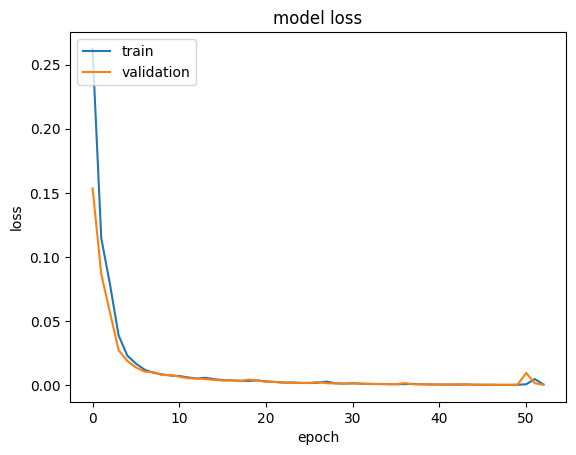

In [295]:
plot_history(history)

❓ **Question** ❓ Plot many true sequences, as well as their predictions, to visualize your model performance

7/7 [==============================] - 2s 9ms/step
PREDICTED SERIES VS ACTUAL SERIES
PREDICTED VALUES: BLUE
ACTUAL VALUES: GREEN


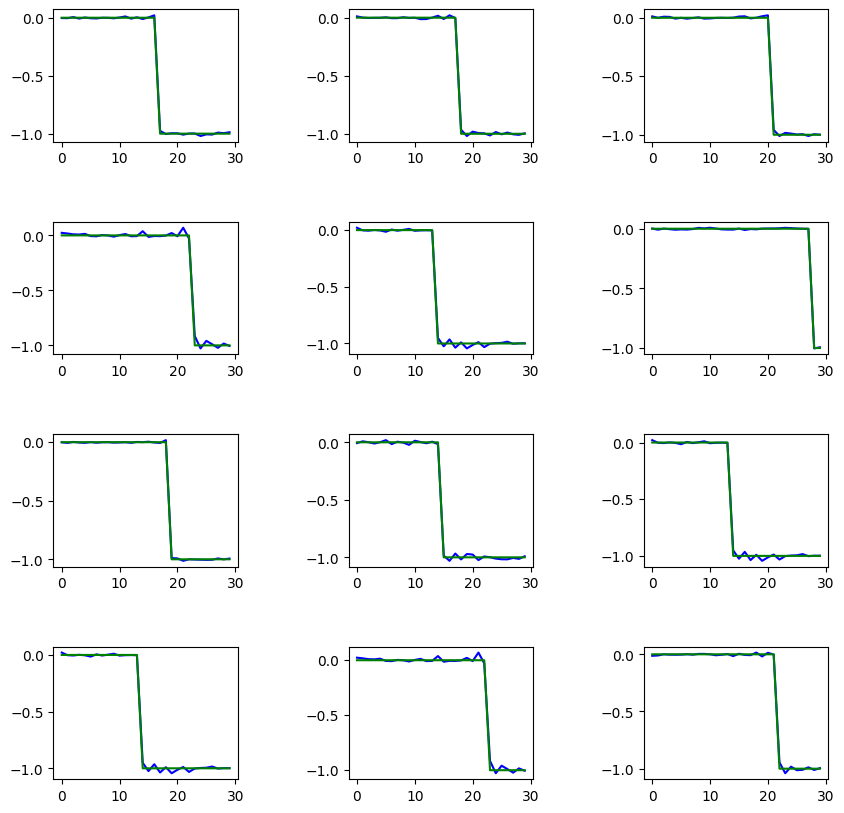

In [296]:
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)

rows = 4
columns = 3

fig, axes = plt.subplots(rows, columns)
fig.set_size_inches(10, 10)
fig.subplots_adjust(hspace=0.6, wspace=0.6)

print("PREDICTED SERIES VS ACTUAL SERIES")
print("PREDICTED VALUES: BLUE")
print("ACTUAL VALUES: GREEN")

current_result = 0
for r in range(rows):
    for c in range(columns):
        sns.lineplot(y_pred[current_result], ax=axes[r][c], color='blue')
        sns.lineplot(y_test[current_result], ax=axes[r][c], color='green')
        current_result += 1


🏁 **Congratulation**